# 7. Gyakorlat: Mesterséges mélytanulás

---
## Könyvtárak

In [1]:
!pip install alexnet_pytorch

In [1]:
import pandas as pd
import numpy as np
import tarfile
import cv2 as cv
import itertools
import matplotlib.pyplot as plt
import warnings
from PIL import Image, ImageFile
from sklearn.metrics import confusion_matrix
from itertools import compress

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets.utils import download_url
from torchvision import transforms
from alexnet_pytorch import AlexNet

warnings.simplefilter(action='ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES=True

---
## Adathalmaz

Using downloaded and verified file: ./imagenette-160.tgz
Számítóegység: cpu


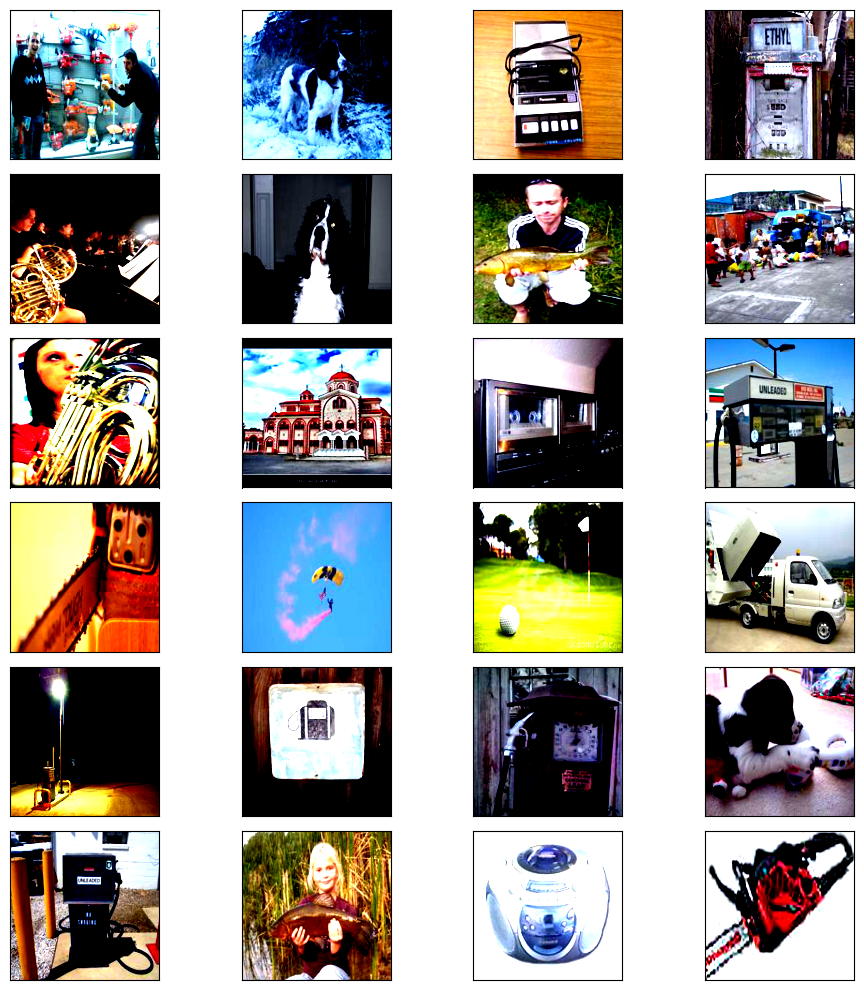

In [5]:
# Kép létezésének ellenőrzése
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

# Transzformációs csővezeték a képek betöltéséhez
img_transforms = transforms.Compose([
    transforms.Resize((150, 150)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # Normalizálás az Imagenette átlaggal és szórással
])

# Adathalmaz letöltése
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
download_url(dataset_url, '.')

# Adathalmaz kicsomagolása
with tarfile.open('./imagenette-160.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

# Tanító és validációs adatok betöltése
train_data = torchvision.datasets.ImageFolder(root='./data/imagenette-160/train', transform=img_transforms, is_valid_file=check_image)
val_data = torchvision.datasets.ImageFolder(root='./data/imagenette-160/val', transform=img_transforms, is_valid_file=check_image)

# Tanító adatok szétválasztása tanító és teszt adatokra
train_size = int(len(train_data) * 0.7)
test_size = len(train_data) - train_size
train_set, test_set = torch.utils.data.random_split(train_data, [train_size, test_size])

# Adatbetöltő objektumok inicializálása
batch_size = 24
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size) 
test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size) 

# Számítóegység átállítása nvidia GPU-ra, ha létezik
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Számítóegység: {device}')

# Adatbetöltők tesztelése
def display_img(img, show=True):
    img = np.clip(img / 2 + 0.5, 0, 1)  # Denormalizálás
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='none')
    if show:
        plt.show()

# Képek ábrázolása egy matplotlib hálón
def img_grid(image):
    plt.figure(figsize=(10, 10))
    for i in range(0, 24):
        plt.subplot(6, 4, i + 1)
        grid_data = image[i]
        display_img(grid_data, show=False)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

image, label = next(iter(test_data_loader))
img_grid(image)

---
## Architektúra

In [8]:
# Architektúra betöltése
model = AlexNet.from_pretrained('alexnet', num_classes = 10)
model.to(device)
model.eval()

# Paraméterek fagyasztása (taníthatatlanná tétele)
for param in model.parameters():
    param.requires_grad = False

# Az utolsó hálózati réteg hozzáadása és ezzel taníthatóvá állítása
model.classifier[6] = nn.Linear(4096, 10)
model = model.to(device)

# Tanítható paraméterek kigyűjtése egy listába
params_to_learn = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_learn.append(param)

# Optimalizáló és költségfüggvény
optimizer = torch.optim.RMSprop(params_to_learn, lr=0.00001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)
loss_fn = torch.nn.CrossEntropyLoss()

# Tensorboard betöltése
!rm -rf runs
%load_ext tensorboard
%tensorboard --logdir runs

Loaded pretrained weights for alexnet
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 573754), started 0:00:48 ago. (Use '!kill 573754' to kill it.)

---
## Tanítás

In [10]:
def train(alexnet, train_loader, val_loader, optimizer, num_epochs, criterion, history={}):
    history['train_loss'] = []
    history['train_acc'] = []
    history['valid_loss'] = []
    history['valid_acc'] = []

    best_model = alexnet
    best_epoch = -1
    min_val_error = float('inf')
    error_going_up = 0
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        # Training phase
        alexnet.train()
        train_loss = 0.0
        train_corrects = 0
        for idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            output = alexnet(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(output, 1)
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects.double() / len(train_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        writer.add_scalar('train/loss', train_loss, epoch)
        writer.add_scalar('train/acc', train_acc, epoch)

        # Validation phase 
        alexnet.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.set_grad_enabled(False):
                output = alexnet(inputs)
                loss = criterion(output, labels)
                
                _, preds = torch.max(output, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        
        history['valid_loss'].append(epoch_loss)
        history['valid_acc'].append(epoch_acc)
        writer.add_scalar('val/loss', epoch_loss, epoch)
        writer.add_scalar('val/acc', epoch_acc, epoch)

        # Early stopping implementation
        if epoch_loss <= min_val_error:
            min_val_error = epoch_loss
            error_going_up = 0
            best_model = alexnet
            best_epoch = epoch
        else:
            error_going_up += 1
            if error_going_up == 5:
                print('Training terminated with early stopping on epoch: ' + str(epoch) + '. Best epoch:' + str(best_epoch))
                break 

        print('{}. Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

    writer.close()
    return best_model, history, best_epoch

In [11]:
best_model, history, best_epoch = train(model, train_data_loader, val_data_loader, optimizer, 30, loss_fn)

0. Loss: 0.3441 Acc: 0.8920
1. Loss: 0.3135 Acc: 0.9040
2. Loss: 0.3065 Acc: 0.9100
3. Loss: 0.3016 Acc: 0.9120
4. Loss: 0.3012 Acc: 0.9120
5. Loss: 0.3020 Acc: 0.9160
6. Loss: 0.3020 Acc: 0.9200
7. Loss: 0.3081 Acc: 0.9200
8. Loss: 0.3133 Acc: 0.9180
Training terminated with early stopping on epoch: 9. Best epoch:4


#### Show results (accuracy and loss) on training and validation sets

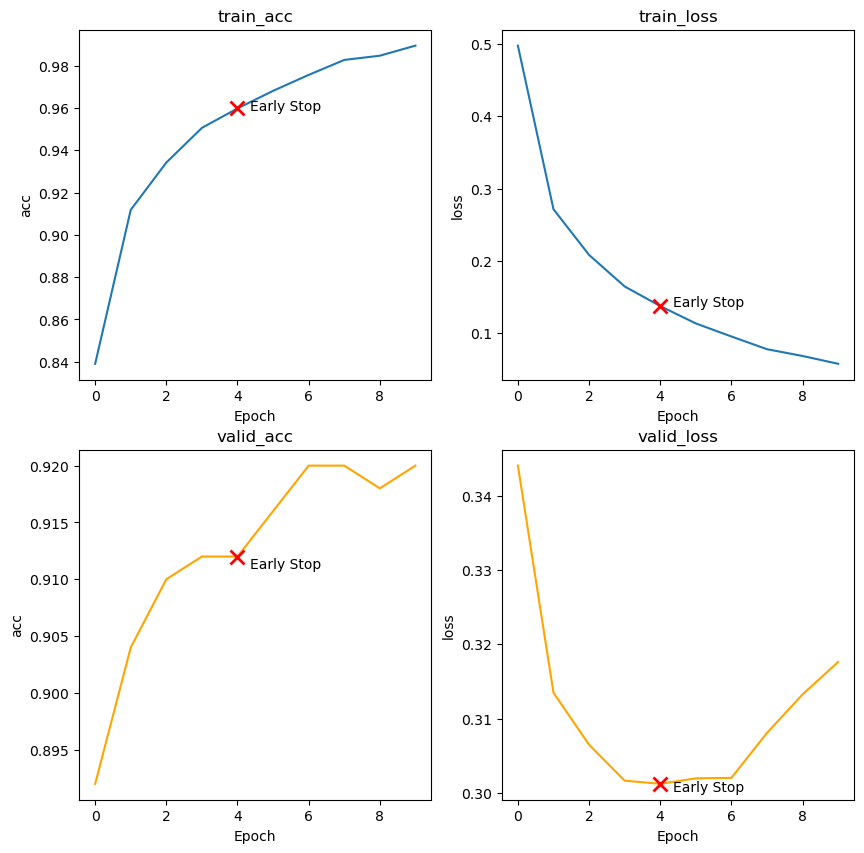

In [16]:
plt.figure(figsize=(10, 10))
for i,name in enumerate(['train_acc','train_loss','valid_acc','valid_loss']):
    plt.subplot(2, 2, i+1)

    if (name.split('_')[0]=='valid'):
        plt.plot(history[name], color='orange')
    else:
        plt.plot(history[name])

    plt.plot(best_epoch, history[name][best_epoch], color='red', marker='x', markersize=10, markeredgewidth='2')
    plt.annotate('Early Stop', xy = (best_epoch+0.35, history[name][best_epoch]-0.001))
    plt.title(name)
    plt.ylabel(name.split('_')[1])
    plt.xlabel('Epoch')
plt.show()

## 3. Conclusion (Evaluation)

#### Evaluate your model

In [17]:
def test(model, loss_fn, test_loader, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    model.eval()
    num_correct = 0 
    num_examples = 0
    valid_loss = 0.0

    for batch in test_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        loss = loss_fn(output,targets) 
        valid_loss += loss.data.item() * inputs.size(0)
        correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1],targets)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]

    valid_loss /= len(test_loader.dataset)
    print('Test run:')
    print('Loss: {:.2f}, Accuracy = {:.2f}'.format(valid_loss, num_correct / num_examples))

In [18]:
test(best_model, loss_fn, test_data_loader, device)

Test run:
Loss: 0.30, Accuracy = 0.91


In [19]:
# Set up the labels for the predictions
labels = ['Fish', 'Dog', 'Casette player', 'Chainsaw', 'Church', 'Horn', 'Truck', 'Gaspump', 'Golfball', 'Parachute']

In [20]:
# Load predictions / labels / X_data / predicted probabilities into lists for further examination
y_pred, y_true, y_inst, y_prob = [], [], [], []

for batch in test_data_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        _, preds = torch.max(output, 1)
        y_prob.extend(output)
        y_inst.extend(inputs)
        y_pred.extend([labels[x] for x in preds])
        y_true.extend([labels[x] for x in targets])

In [21]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

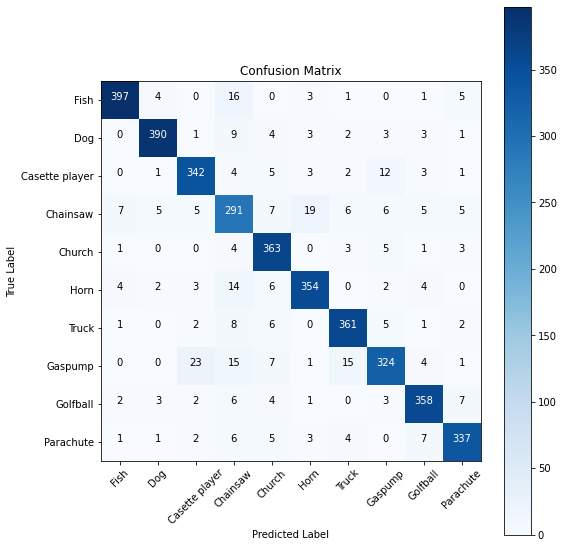

In [22]:
# Create a confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred, labels=labels) 
plot_confusion_matrix(confusion_mtx, classes = labels) 

<Figure size 1080x1080 with 0 Axes>

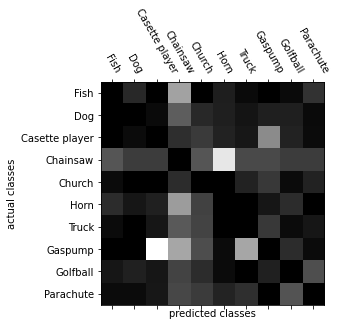

In [23]:
# Normalized confusion matrix
row_sums = confusion_mtx.sum(axis=1, keepdims=True)
norm_conf_mx = confusion_mtx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plt.figure(figsize=(15,15))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.ylabel('actual classes')
plt.xlabel('predicted classes')
plt.xticks(range(10),labels=labels, rotation=300)
plt.yticks(range(10),labels=labels)
plt.show()

#### Show some predictions

In [24]:
def get_quadrant(j):
    r = j%6
    b = 3
    c = 18
    if ((r > 0) & (r <= b) & (j/c<=1)):
        return 0
    elif (((r == 0) or (r > b)) & (j/c<=1)):
        return 1    
    elif ((r > 0) & (r <= b) & (j/c>1)):
        return 2
    elif (((r==0) or (r > b)) & (j/c>1)):
        return 3

def plot_images(quads, titles, a=6, b=6):
    counts = [0, 0, 0, 0]
    plt.figure(figsize=(16, 16))
    for i in range(1, a*b+1):
        plt.subplot(a, b, i)
        curr_iter = get_quadrant(i)
        curr_quad_data = quads[curr_iter]

        if (counts[curr_iter] == len(curr_quad_data)):
            plt.text(0.5, 0.5,'No image to show. \n Reached end of list', horizontalalignment='center', verticalalignment='center')
            continue

        curr_count = counts[curr_iter]
        grid_data = curr_quad_data[curr_count]
        counts[curr_iter] += 1 
        display_img(grid_data, show=False)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_title(titles[curr_iter], size=8)
    plt.tight_layout()

filt_conf = lambda cl_a, cl_b, y_true=y_true, y_pred=y_pred: [True if x[0]==cl_a and x[1]==cl_b else False for x in zip(y_true, y_pred)]

filt_list = lambda y_inst, filt_config: list(compress(y_inst, filt_config))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

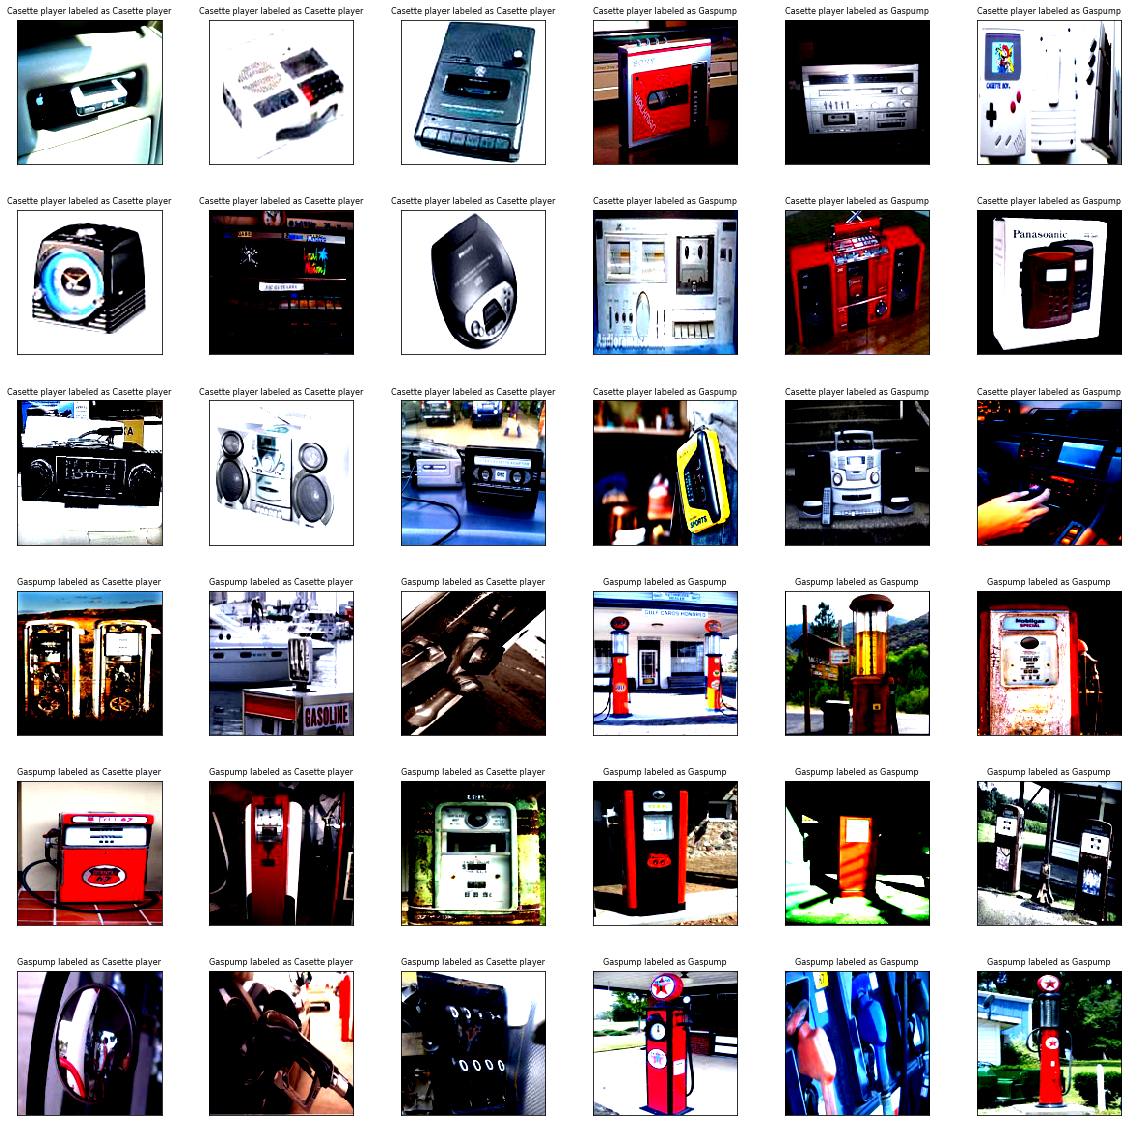

In [25]:
# Show images from the most mixed-up classes
cl_a = 'Casette player'
cl_b = 'Gaspump'

quads = [filt_list(y_inst, filt_conf(cl_a, cl_a)), # true: casette; pred: casette
         filt_list(y_inst, filt_conf(cl_a, cl_b)), # true: casette; pred: gaspump
         filt_list(y_inst, filt_conf(cl_b, cl_a)), # true: gaspump; pred: casette
         filt_list(y_inst, filt_conf(cl_b, cl_b))] # true: gaspump; pred: gaspump

titles = [cl_a + ' labeled as ' + cl_a, 
          cl_a + ' labeled as ' + cl_b, 
          cl_b + ' labeled as ' + cl_a, 
          cl_b + ' labeled as ' + cl_b]

plot_images(quads, titles)

In [26]:
# Methods to show error cells
def get_ind(x, lst=labels):
    for i in range(len(labels)):
        if labels[i] == x:
            return i

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n, nrows, ncols = 0, 2, 3
    plt.figure(figsize=(16,14))
    plt.suptitle('Instances with the largest error rate', size=24)
    for i in range(1, nrows*ncols+1):
        plt.subplot(nrows, ncols, i)
        error = errors_index[n]
        display_img(img_errors[error], show=False)
        plt.gca().set_title("Predicted label: {}\nTrue label: {}".format(pred_errors[error], labels[obs_errors[error]]), size=12)
        plt.xticks([])
        plt.yticks([])
        n += 1
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


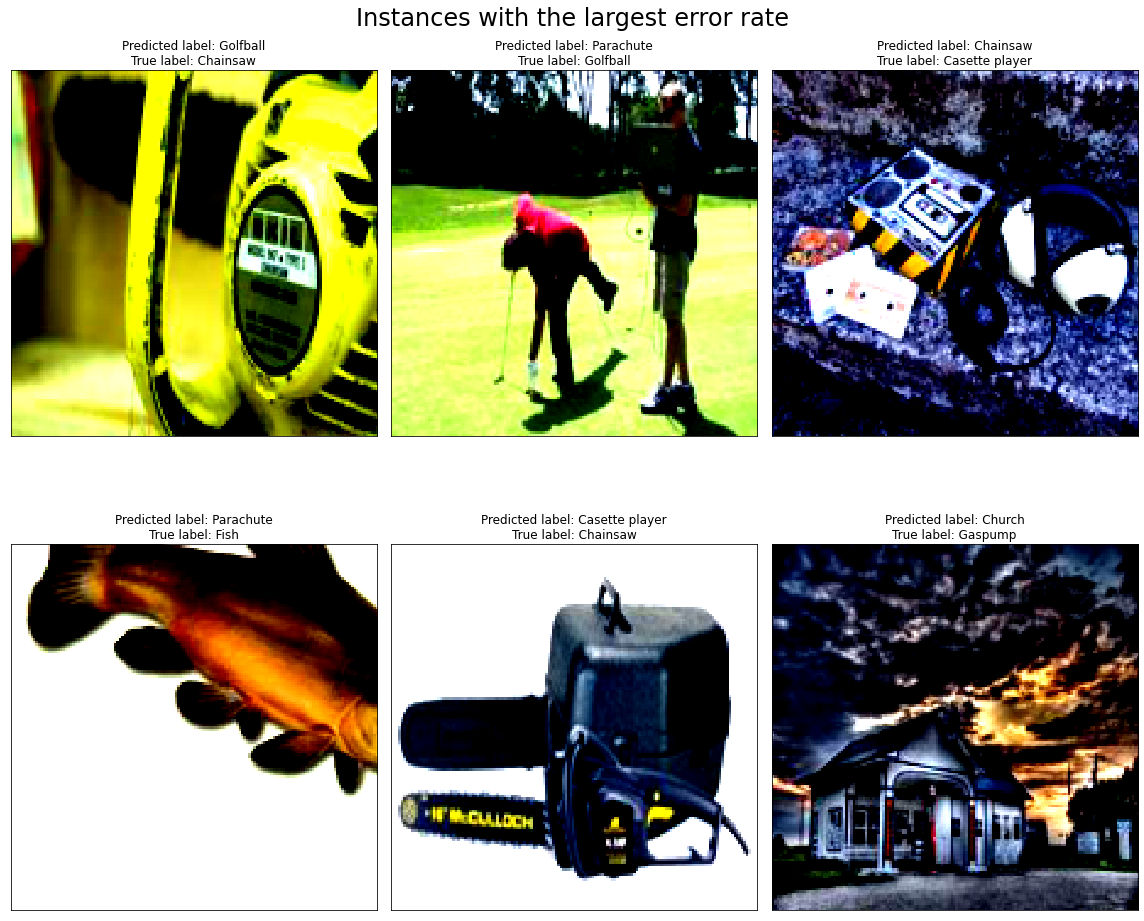

In [27]:
# Calculate individual error for images and show the instances with the largest error
errors = [x!=y for x,y in zip(y_true, y_pred)]

y_pred_classes_errors = filt_list(y_pred, errors)
y_prob_errors = [[float(y) for y in x] for x in filt_list(y_prob, errors)]
y_true_errors = [get_ind(x) for x in filt_list(y_true, errors)] 
x_val_error = filt_list(y_inst, errors)

Y_pred_errors_prob = [float(max(x)) for x in y_prob_errors] 
true_prob_errors = np.diagonal(np.take(y_prob_errors, y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

most_important_errors = sorted_dela_errors[-6:]
display_errors(most_important_errors, x_val_error, y_pred_classes_errors, y_true_errors)

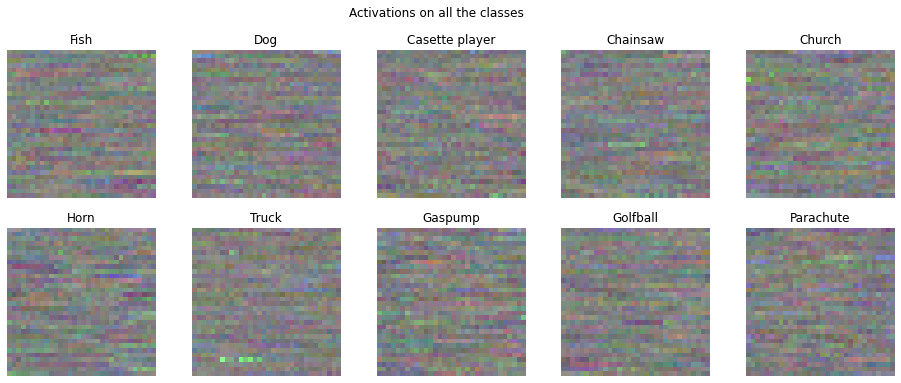

In [28]:
# Visualize Activations
w = best_model.features[10].weight.detach().cpu().numpy()
buff = int(w.size / 32 / 32 / 3)
w = w.reshape(buff, 3, 32, 32).transpose(0, 2, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = labels

plt.figure(figsize=(16,6))
plt.suptitle('Activations on all the classes')
for i in range(10):
  plt.subplot(2, 5, i + 1)
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

In [29]:
# Get convolutional layers and their weights
model_weights = [] 
conv_layers = [] 

model_children = [x for x in [x for x in best_model.children()][0]]


counter = 0 
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 5


In [30]:
# List convolutional layers and their weights
for weight, conv in zip(model_weights, conv_layers):
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) ====> SHAPE: torch.Size([64, 3, 11, 11])
CONV: Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([192, 64, 5, 5])
CONV: Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([384, 192, 3, 3])
CONV: Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 384, 3, 3])
CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 256, 3, 3])


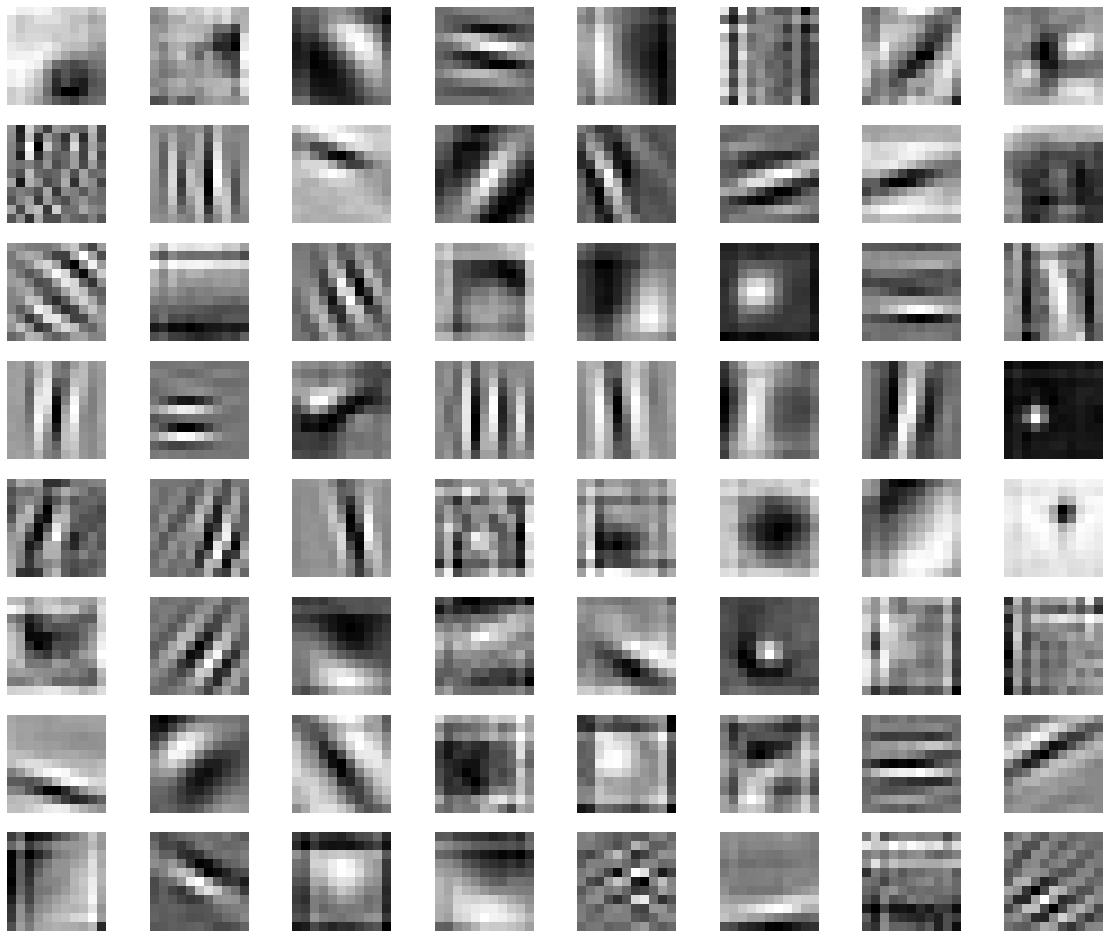

In [31]:
# Visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) 
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

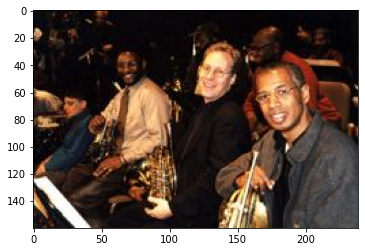

In [32]:
# Test the convolutional network activations on a single image
lst_images = ['/content/data/imagenette-160/train/n01440764/n01440764_10108.JPEG',
              '/content/data/imagenette-160/train/n02102040/n02102040_1011.JPEG',
              '/content/data/imagenette-160/train/n02979186/n02979186_10041.JPEG',
              '/content/data/imagenette-160/train/n03000684/n03000684_1000.JPEG',
              '/content/data/imagenette-160/train/n03028079/n03028079_10103.JPEG',
              '/content/data/imagenette-160/train/n03394916/n03394916_11289.JPEG',
              '/content/data/imagenette-160/train/n03417042/n03417042_10126.JPEG',
              '/content/data/imagenette-160/train/n03425413/n03425413_10350.JPEG',
              '/content/data/imagenette-160/train/n03445777/n03445777_10033.JPEG',
              '/content/data/imagenette-160/train/n03888257/n03888257_10044.JPEG']

img = cv.imread(lst_images[np.random.randint(0,10)])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [33]:
# Transform the image
img = np.array(img)

vis_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),])

img = vis_transform(img)
print(img.size())

img = img.unsqueeze(0)
print(img.size())

torch.Size([3, 150, 150])
torch.Size([1, 3, 150, 150])


In [34]:
# Passing the input through each convolutional layer
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

torch.Size([64, 36, 36])
torch.Size([192, 36, 36])
torch.Size([384, 36, 36])
torch.Size([256, 36, 36])
torch.Size([256, 36, 36])


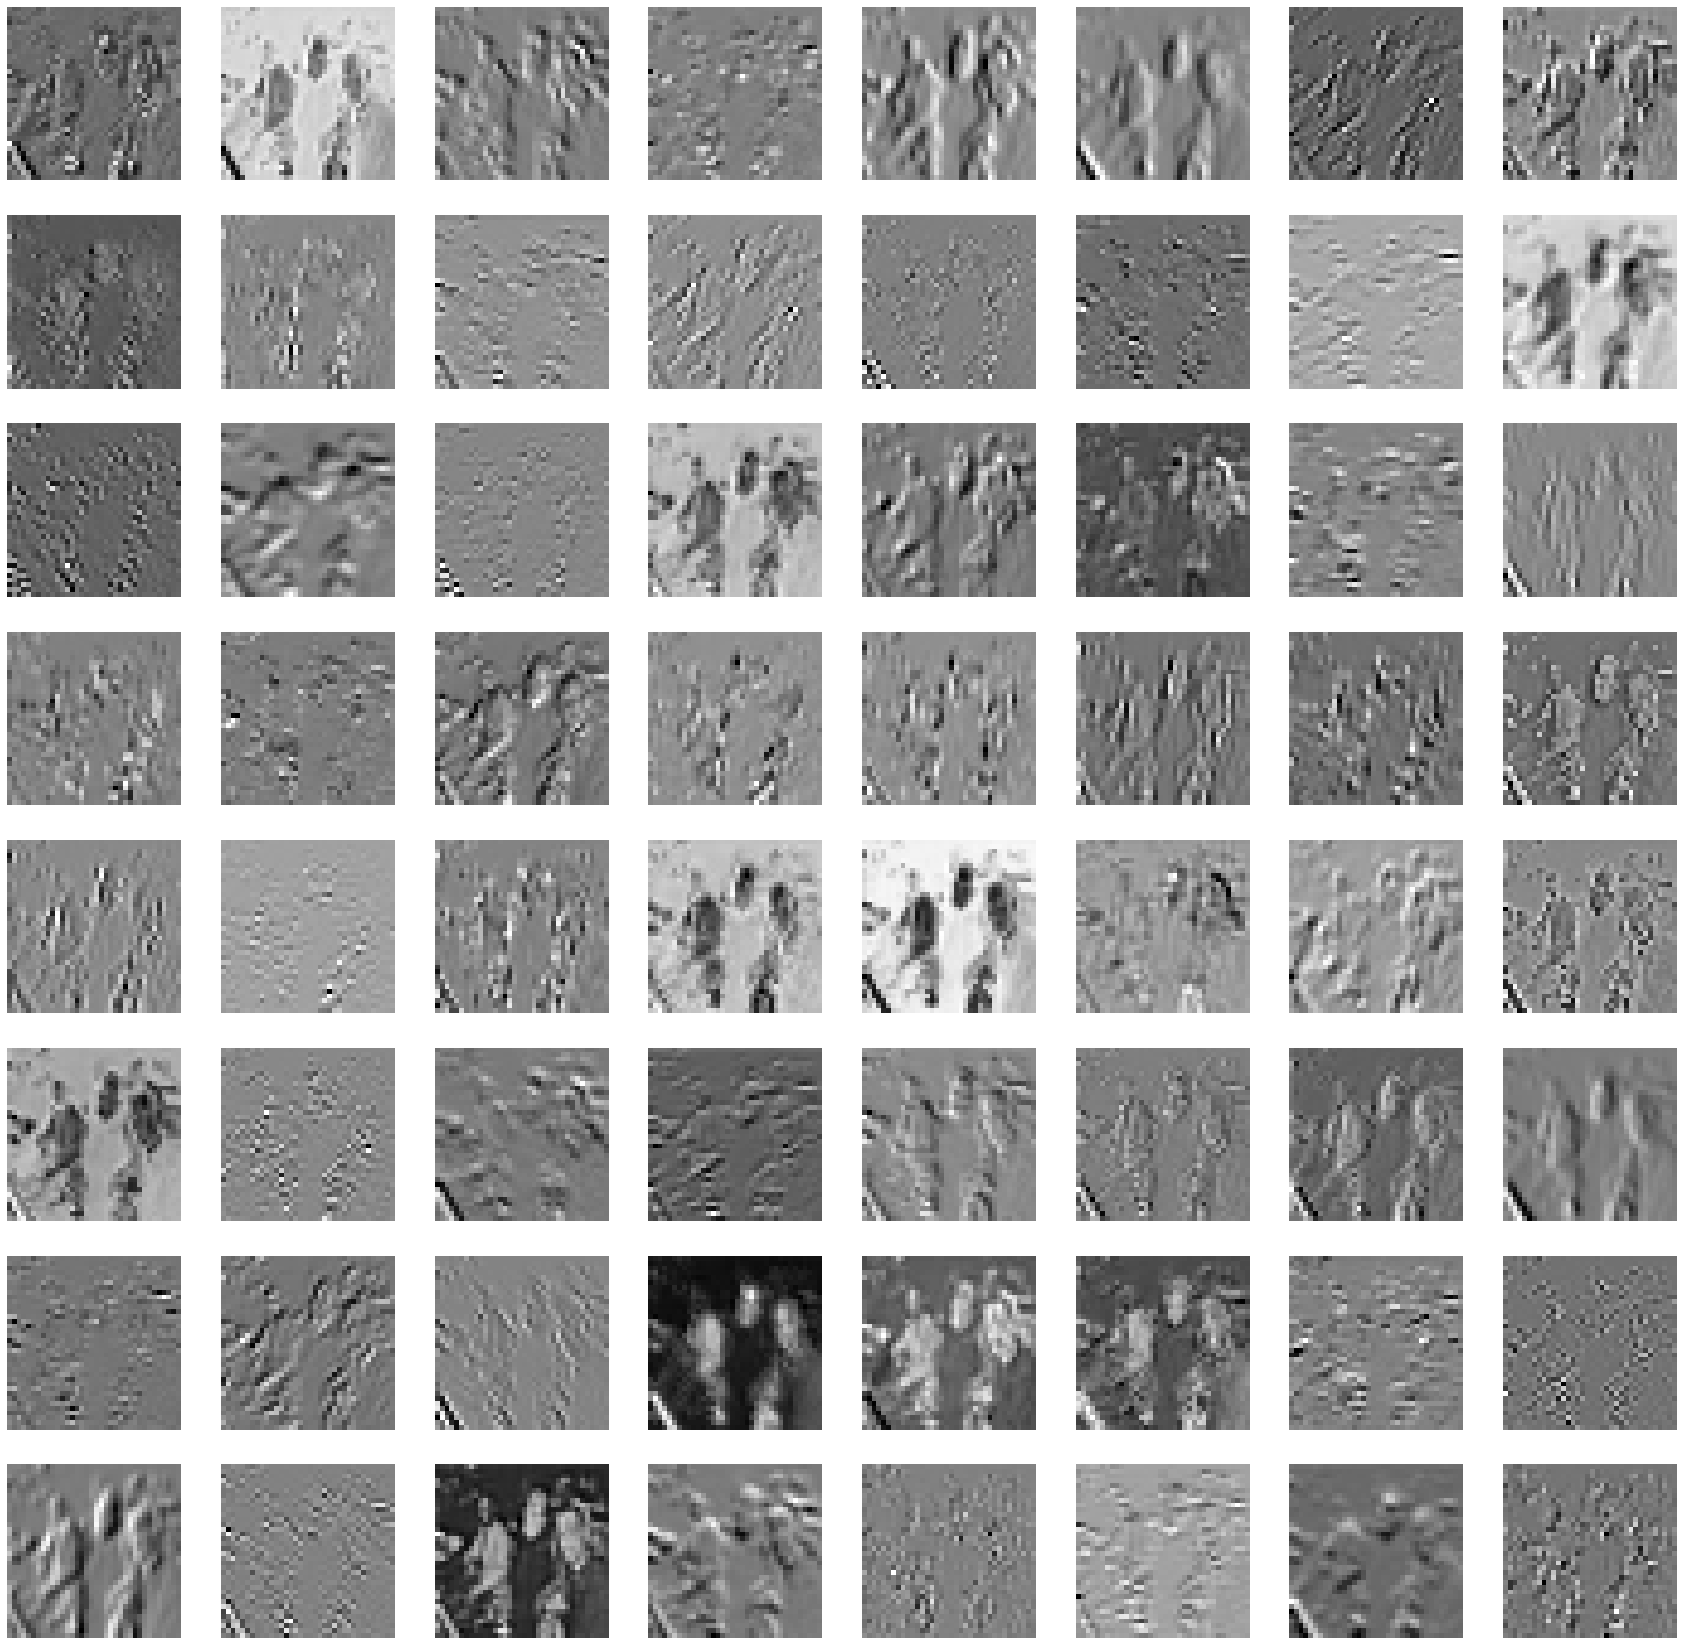

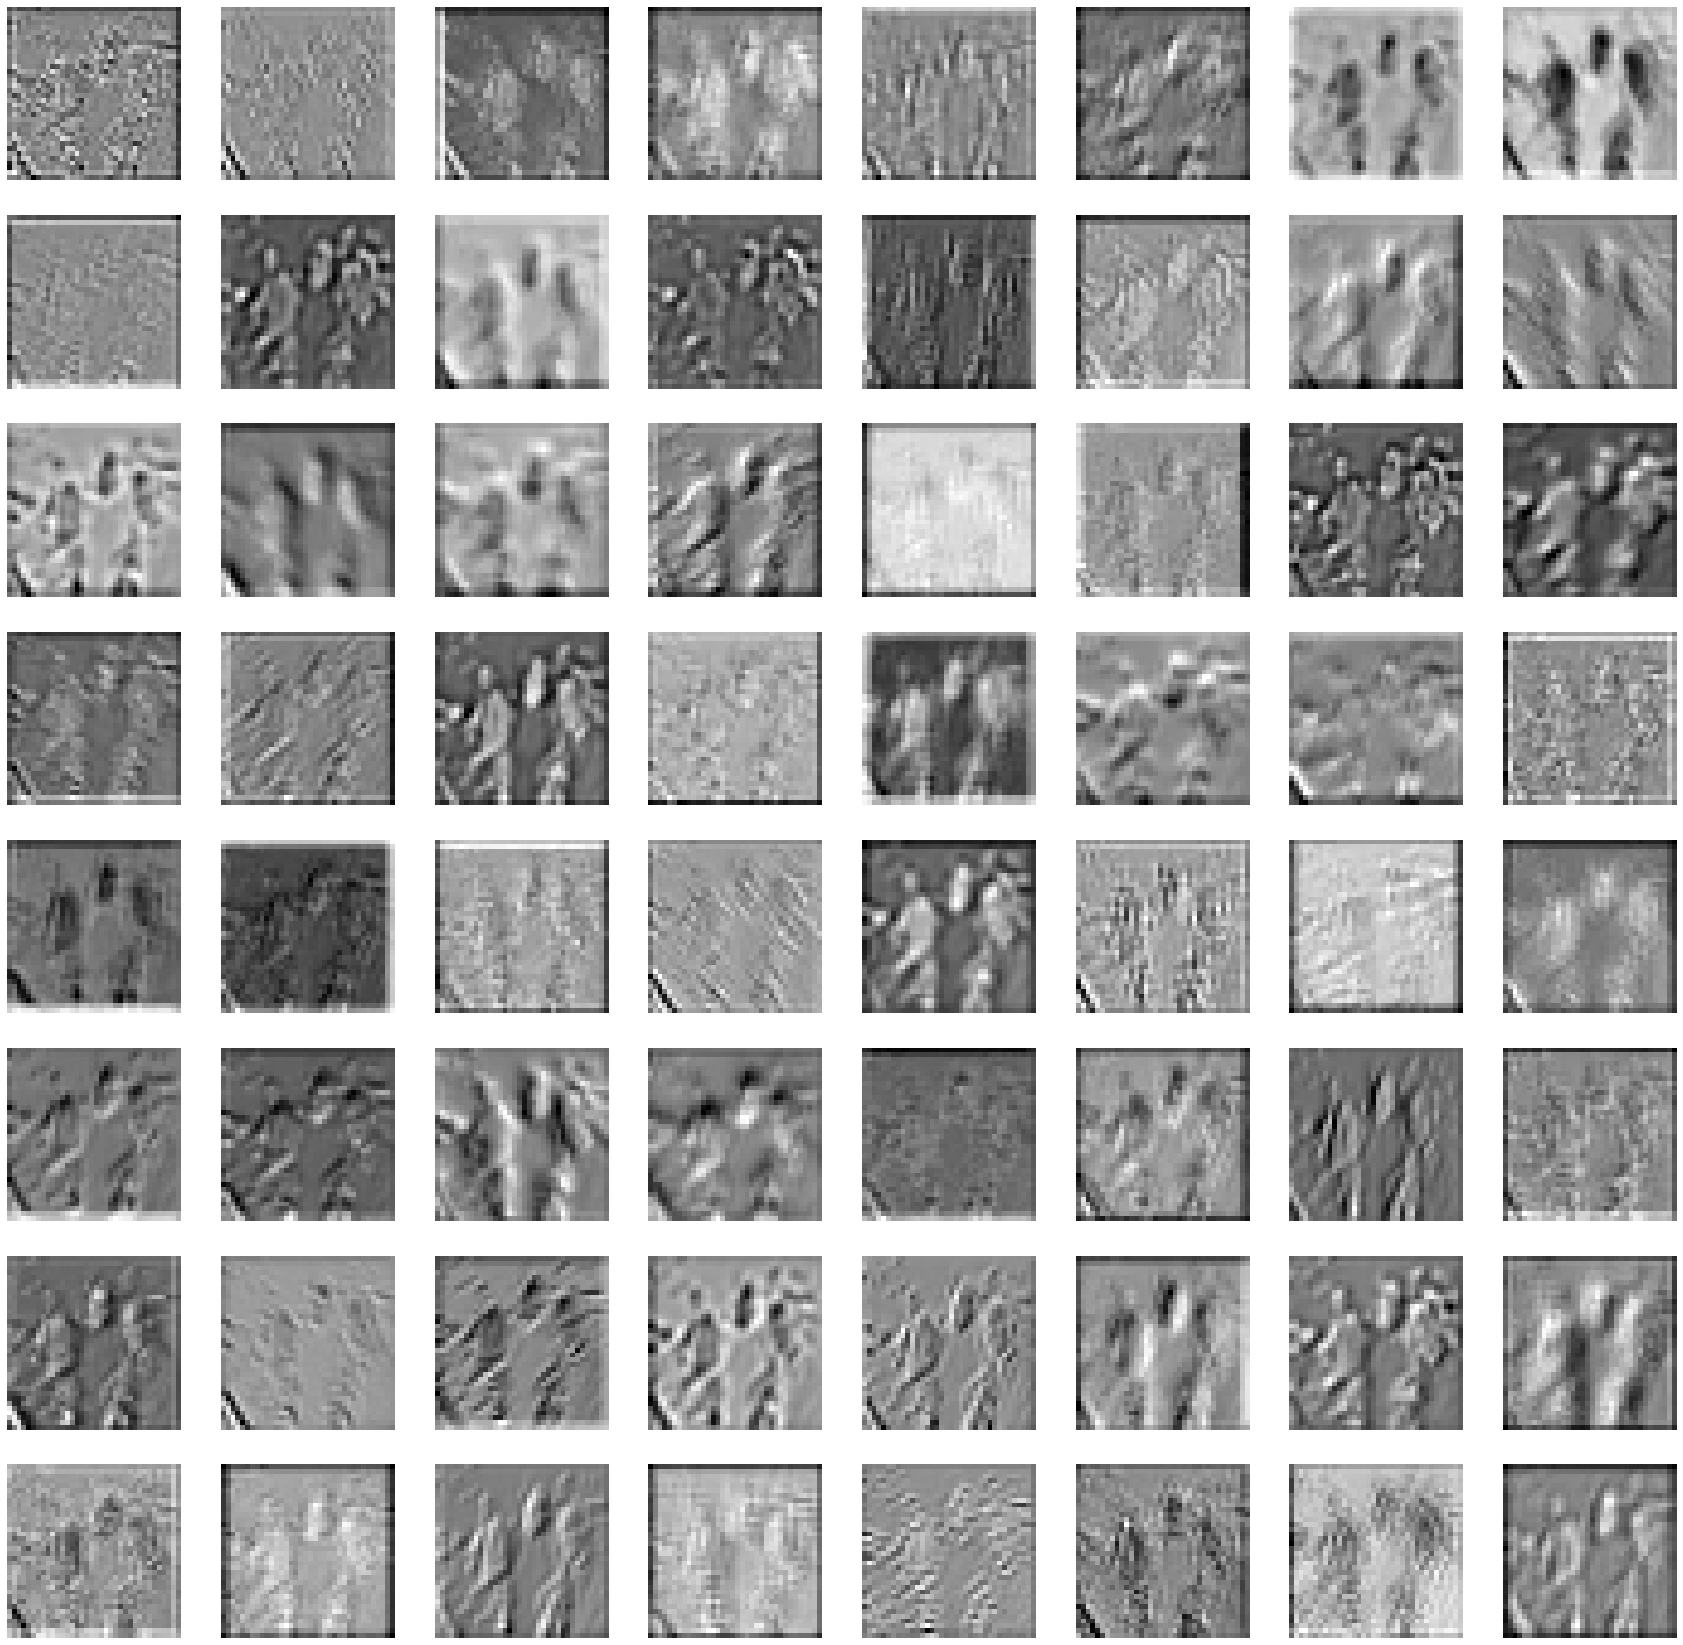

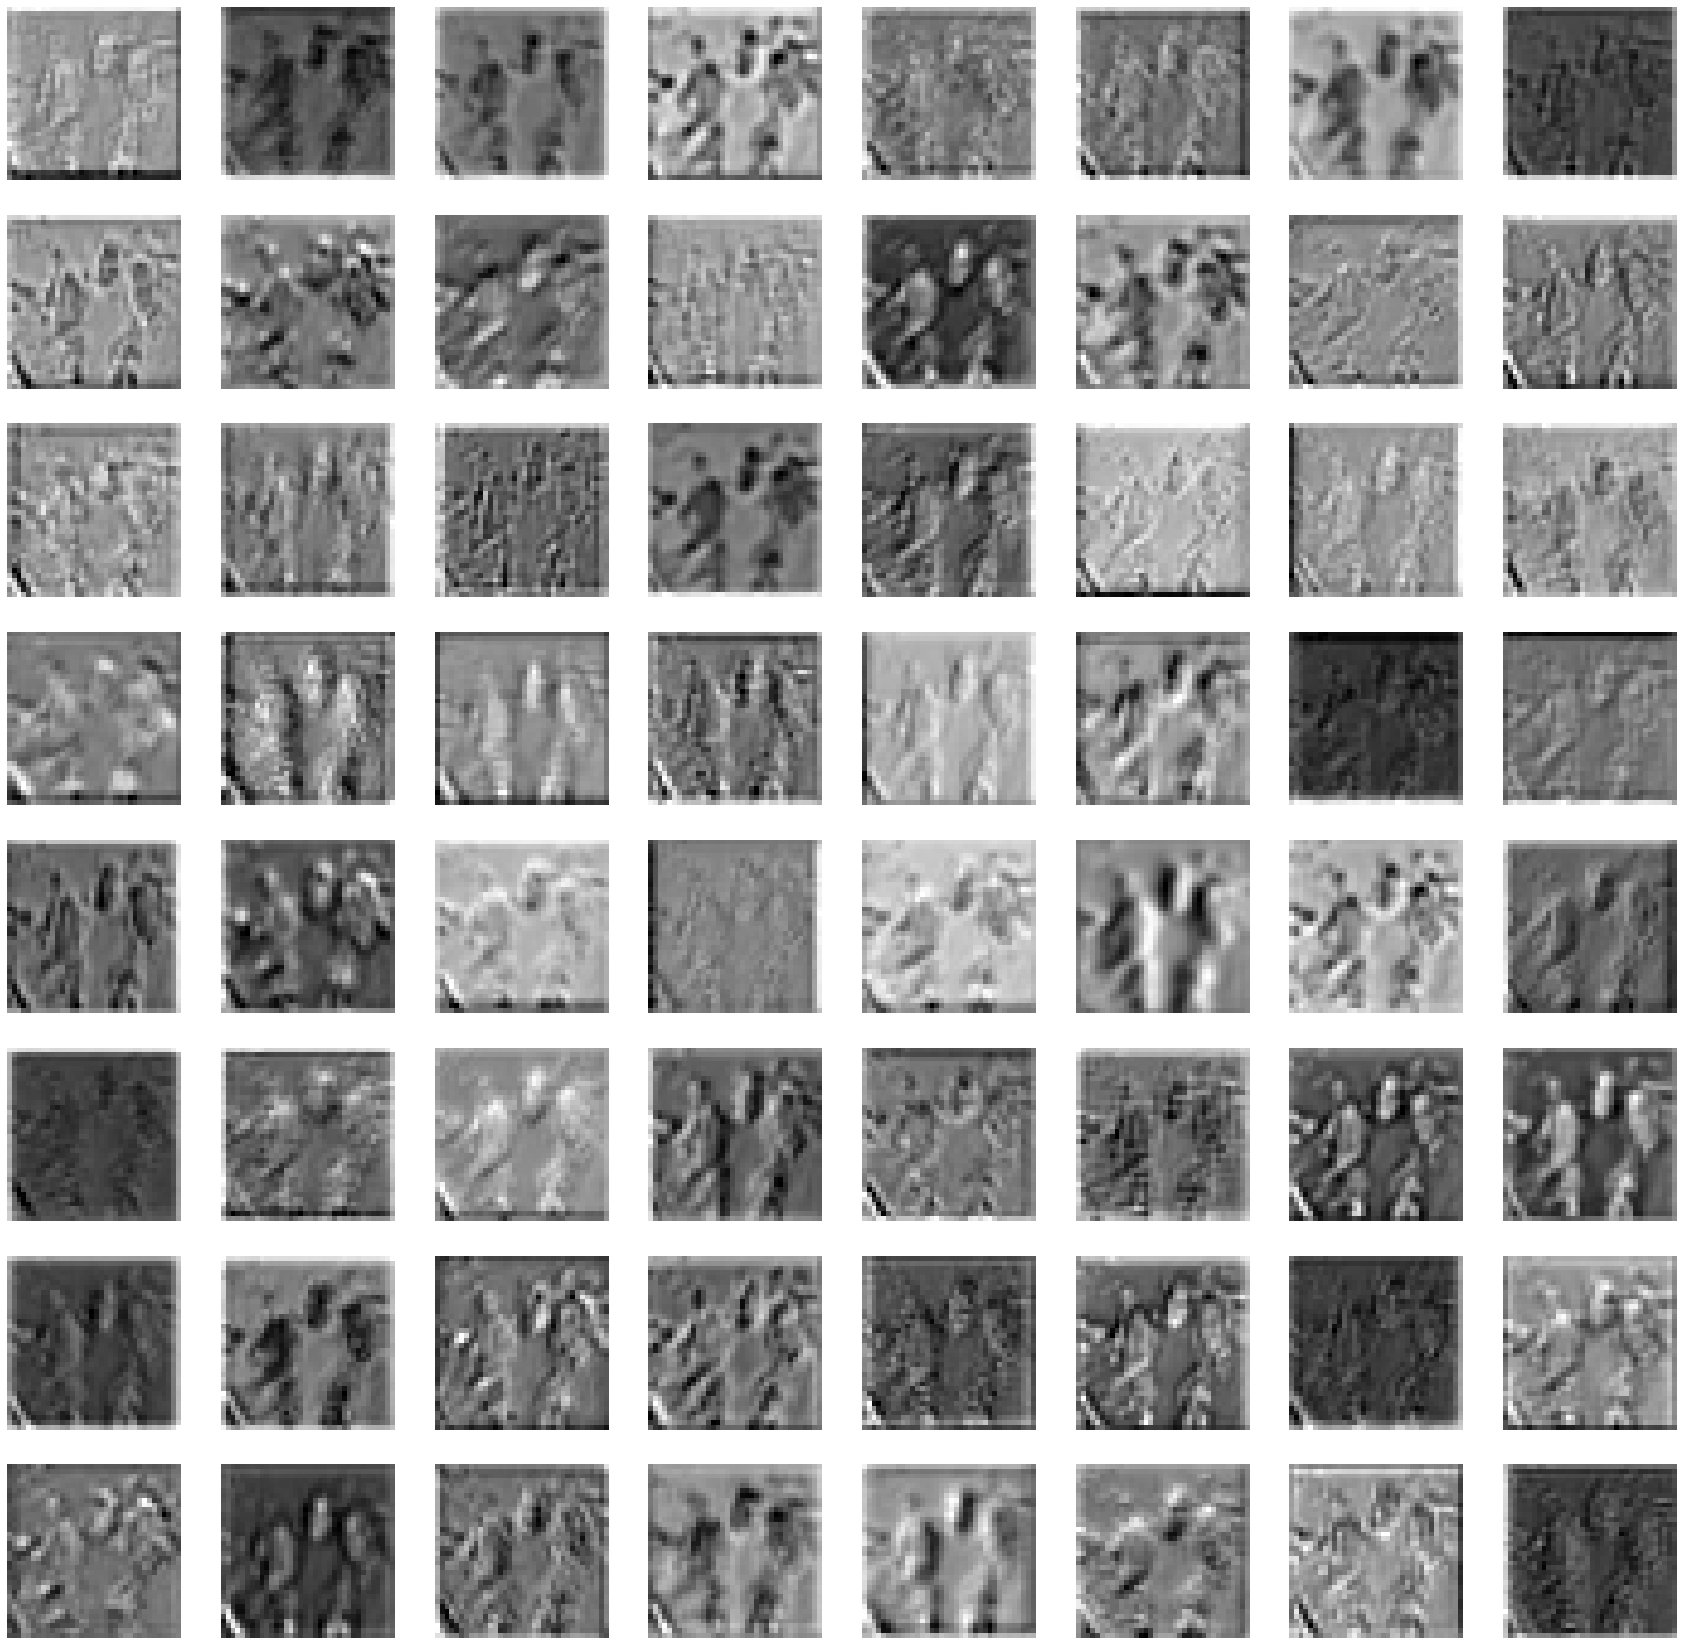

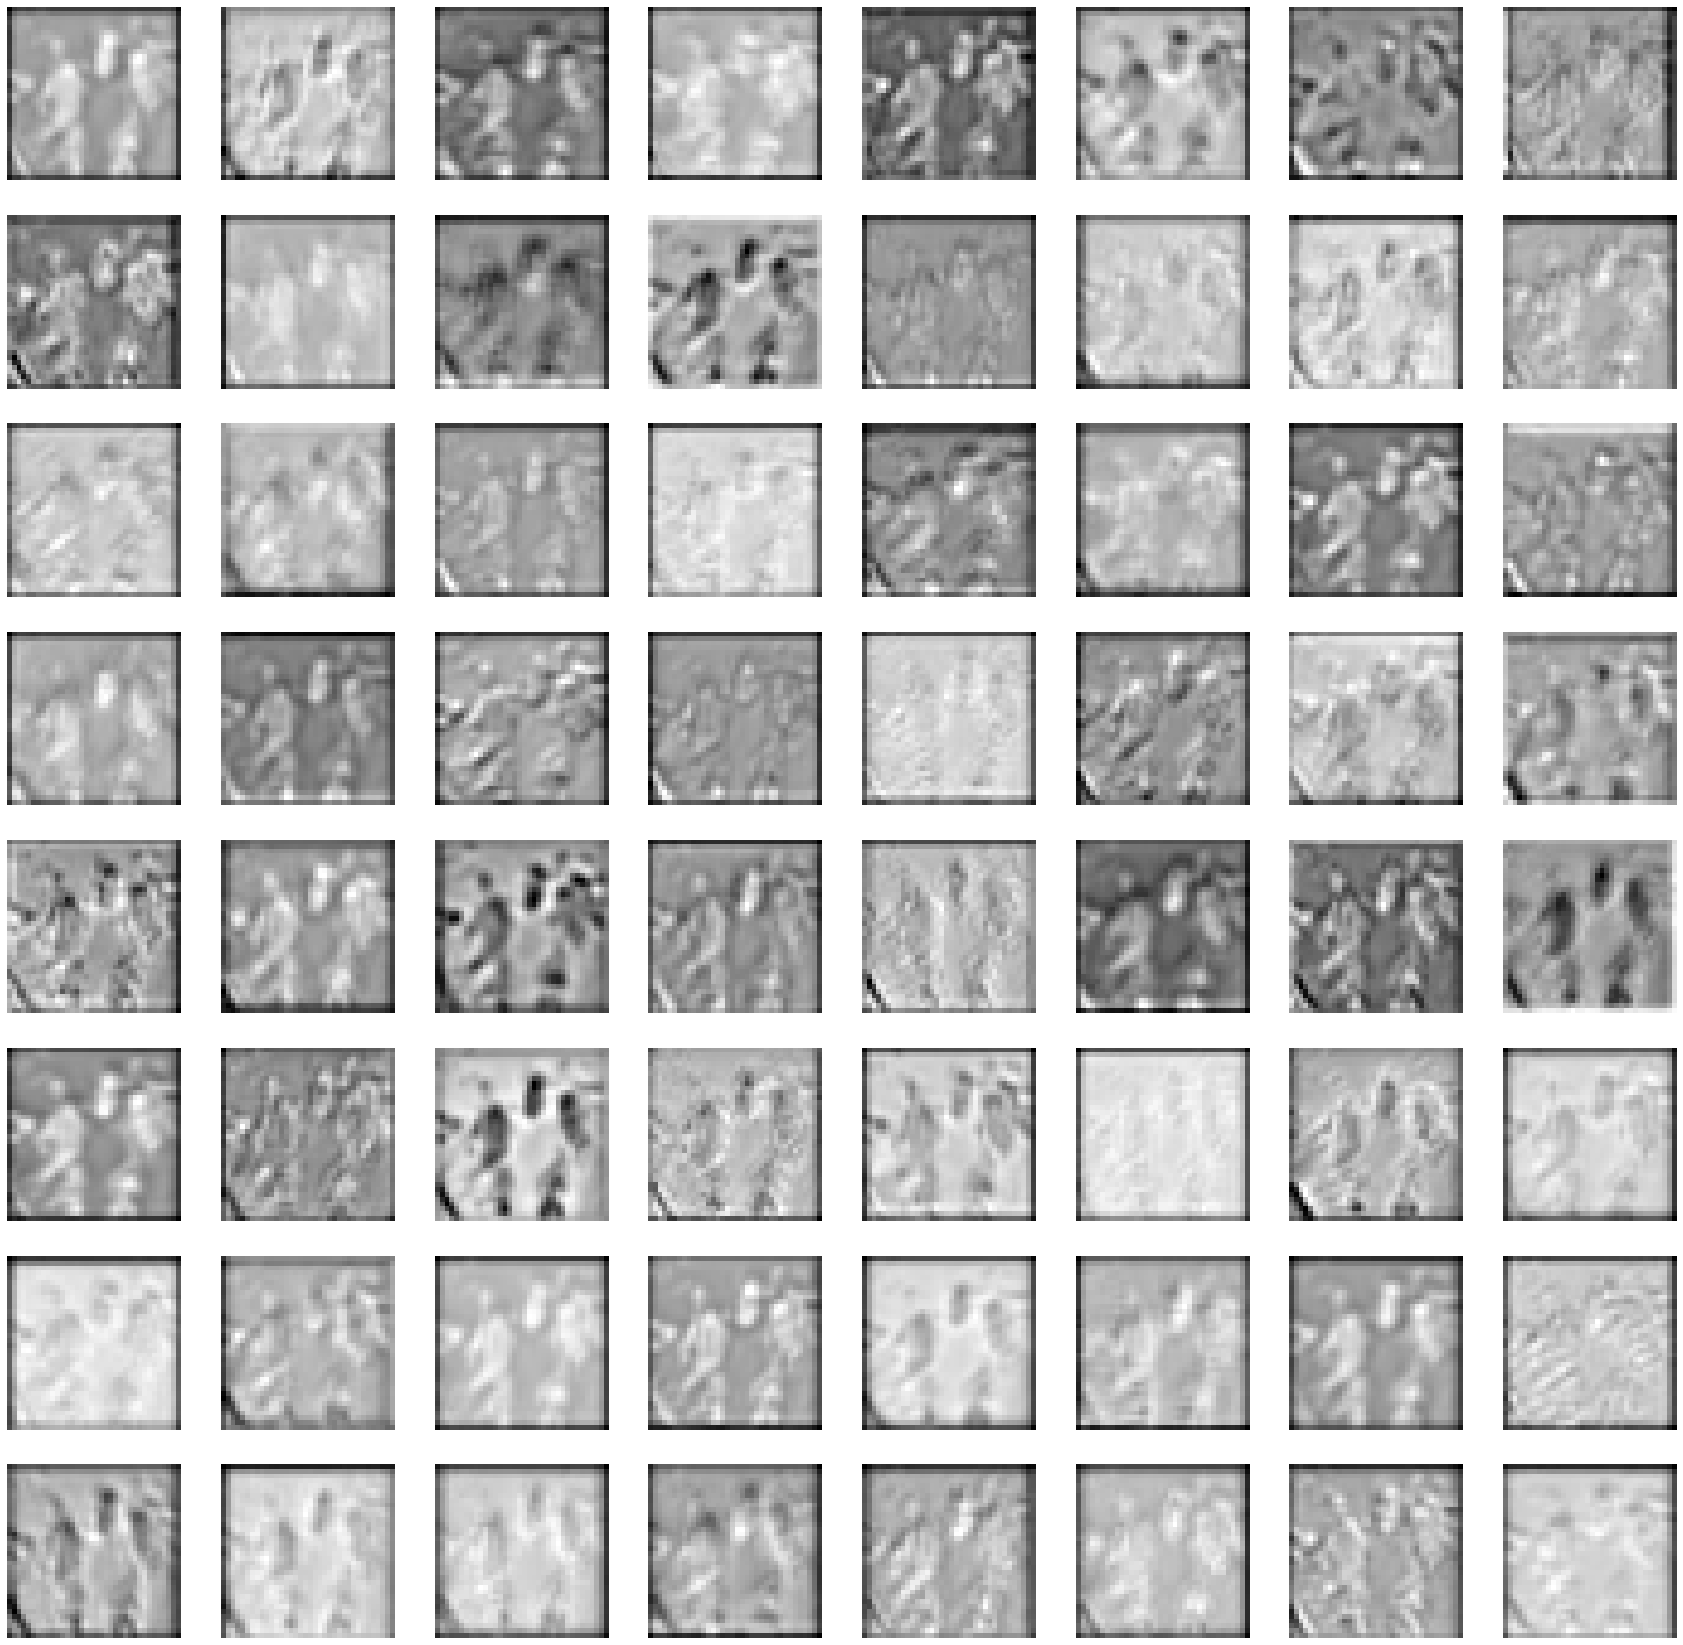

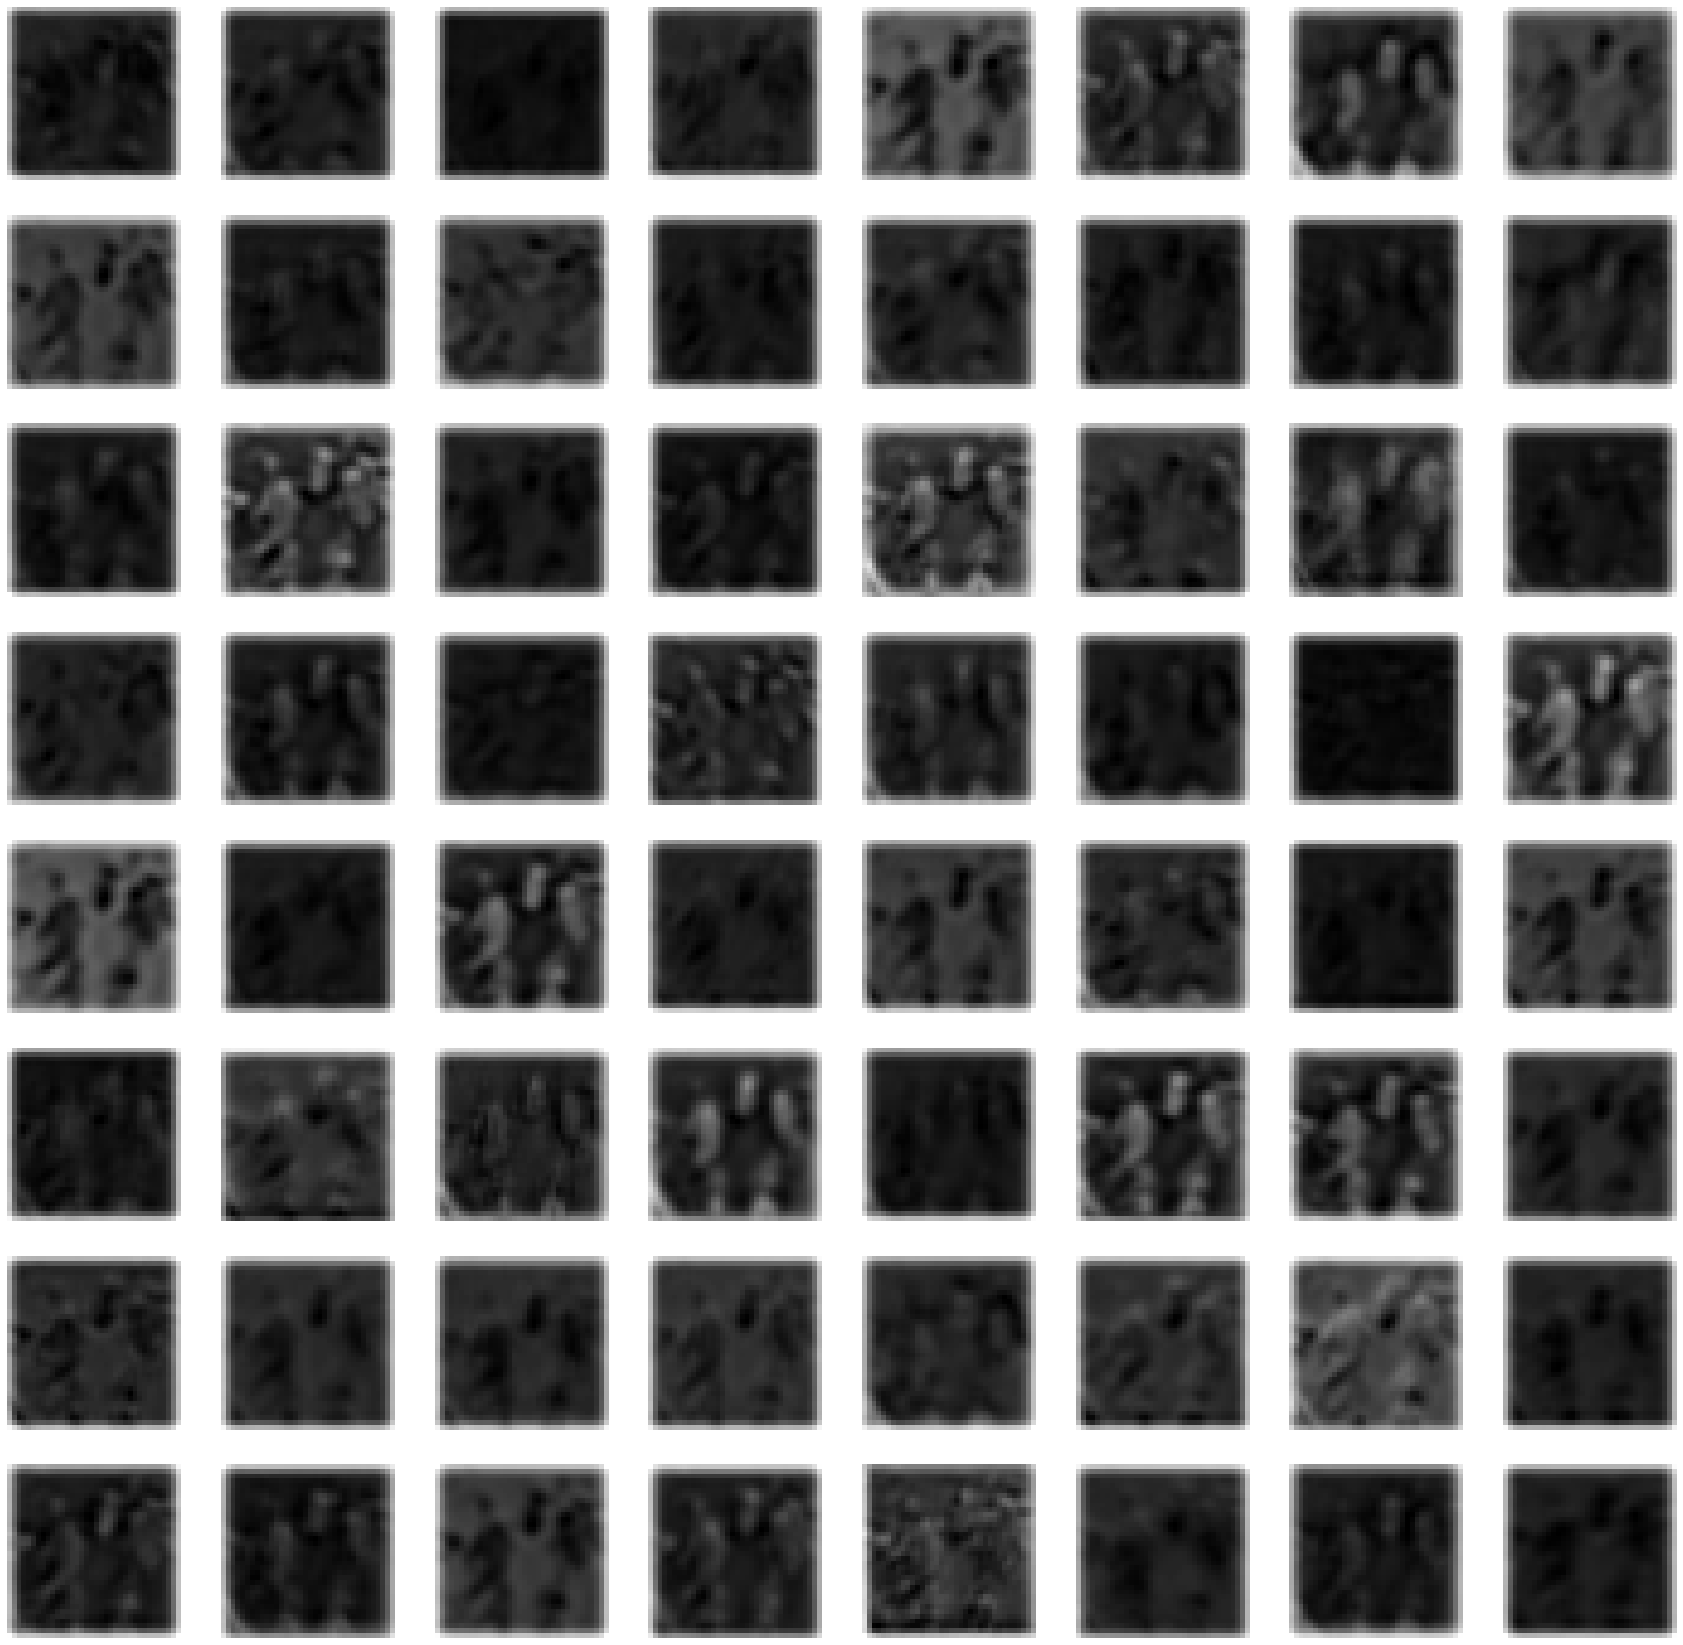

In [35]:
# Visualize feature maps from each layer
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64:
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")

#### Answer the questions

### How good are your results? 
The network's performance was 90% on testing images it has never 'seen' before. This can be classified as a fairly good result in my opinion, after seeing that the most mislabeled instances are sometimes hard to differentiate for even the human eye. 

### Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.
I think the early stopping did it's job to avoid overfitting as much as possible. The dropout layers added regularization properties in the network aswell. With this knowledge I would say the network is in the sweet spot most of the time, but I am sure that there remain overfitted and underfitted parameters in the network. These however don't manifest in a strong manner.